# 엣지검출 (Edge Detection)

- 엣지(edge)
    - 배경과 물체 또는 물체와 물체간의 경계를 말한다.
- 엣지 검출
    - 엣지는 경계가 되는 부분으로 픽셀값이 급격하게 변하게 되므로 그 변화되는 픽셀들을 찾아낸다.
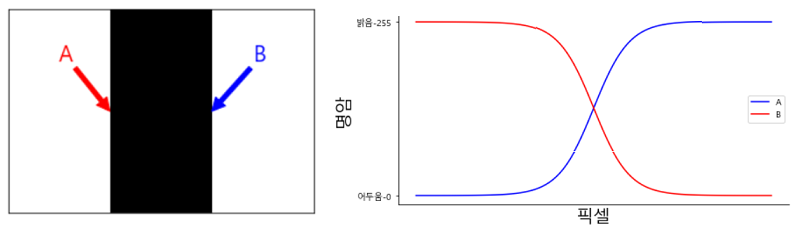
   
   - 엣지 검출을 통해 물체들의 윤곽만 남기고 필요없는 물체나 배경은 제거할 수 있다.
   - Edge detection은 noise의 영향을 많이 받아 일반적으로 blur를 수행 한 후에 Edge detection을 수행

### 엣지 검출과 미분
- 픽셀값의 차이가 큰 부분을 엣지로 판단 하므로 연속된 픽셀값에 미분을 해서 찾아낸다.  
- 그러나 영상의 픽셀값들은 특정 함수에 의해 구해진 값들이 아니므로 미분 근사값을 이용해 구해야 한다.

#### 1차 미분의 근사화
- 전진 차분(Forward difference)
    - $\cfrac{\partial{f}}{\partial{x}}\;\cong\;\cfrac{f(x+h) - f(x)}{h}$
- 후진 차분(Backward difference)
    - $\cfrac{\partial{f}}{\partial{x}}\;\cong\;\cfrac{f(x) - f(x-h)}{h}$
- 중앙 차분(Centered difference)
    - $\cfrac{\partial{f}}{\partial{x}}\;\cong\;\cfrac{f(x+h) - f(x-h)}{2h}$
- 엣지 검출에서는 **중앙 차분**을 사용하며 **h(X의 변화)은 픽셀을 말하며** 이전 픽셀 또는 이후 픽셀과의 차이를 확인하는 것이므로 1로 볼 수 있다. 그러나 우리는 변화율을 보는 것이 목적이므로 1/2로 곱하는 것은 하지 않는다.
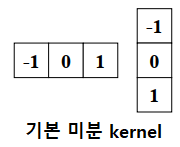

- 주요 미분 커널
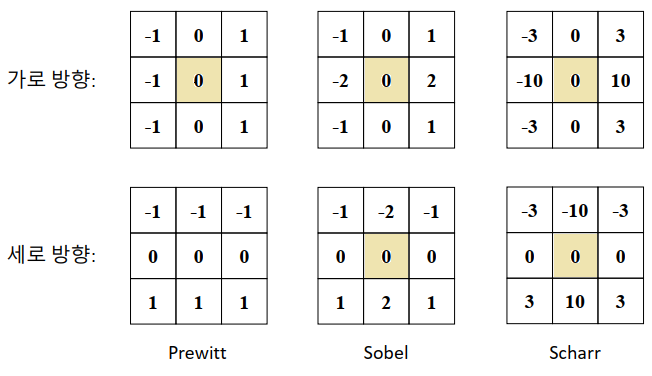

#### 소벨 필터 직접 만들어서 적용

- filter2D(입력영상, 출력영상dtype, filter행렬)
    - filter와 입력영상간의 convolution 연산을 직접 실행하는 함수

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'malgun gothic'
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['axes.titlesize'] = 25

In [3]:
img = cv2.imread('images/sudoku.jpg', cv2.IMREAD_GRAYSCALE)

# cv2.imshow('img', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [4]:
filter_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

filter_y = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])

# 원본 이미지에 필터를 적용(conv 연산)
# -1 : 입력영상의 dtype과 동일한 dtype의 결과를 배열.
sudoku_x = cv2.filter2D(img, -1, filter_x)
sudoku_y = cv2.filter2D(img, -1, filter_y)

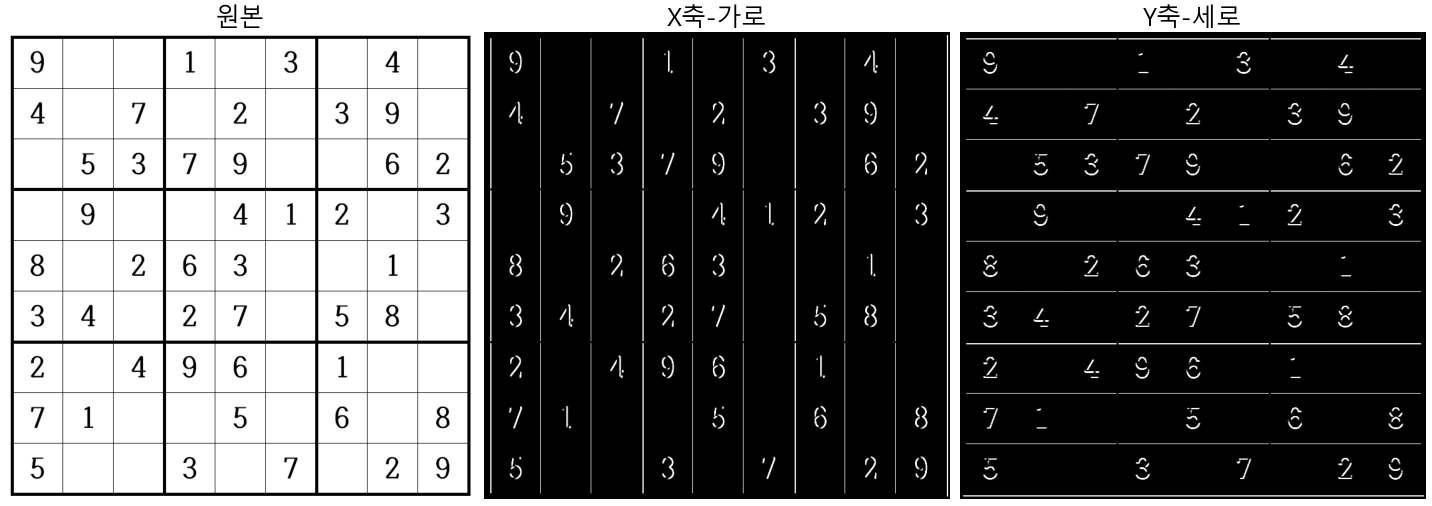

In [5]:
imgs = [img, sudoku_x, sudoku_y]
titles = ['원본', 'X축-가로', 'Y축-세로']
idx = [1,2,3]

plt.figure(figsize=(20,10))
for idx, sudoku, title in zip(idx, imgs, titles):
    plt.subplot(1,3,idx)
    plt.imshow(sudoku, cmap='gray')
    plt.title(title)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

### sobel 함수 이용
- **`cv2.Sobel(src, ddepth, dx, dy, ksize, scale, delta)`**
    - src: 엣지를 검출할 영상
    - ddepth: 출력 영상의 타입. -1로 지정하면 입력영상과 같은 타입 사용.
    - dx, dy: x/y 방향 미분의 차수
        - dx=1, dy=0 : 가로방향
        - dx=0, dy=1 : 세로방향
    - ksize: 커널의 크기. 보통 3으로 준다.
    - scale: 연산결과에 추가적으로 곱할값. Default: 1
    - delta: 연산결과에 추가적으로 더할값. Default: 0
- **`cv2.magnitude(x, y)`**
    - x방향, y방향 필터 결과(미분결과)를 합치는 함수
    - x: x방향 미분 결과
    - y: y방향 미분 결과

In [12]:
lenna_gray = cv2.imread('images/Lenna.png', cv2.IMREAD_GRAYSCALE)

# c2.CV_32F : FLOAT 32
sobel_x= cv2.Sobel(lenna_gray, cv2.CV_32F, 1, 0, ksize=3)
sobel_y= cv2.Sobel(lenna_gray, cv2.CV_32F, 0, 1, ksize=3)

# 150이상은 남기고(255) 미만은 0으로 처리

sobel_x = np.clip
threshold = 100


### Canny
- Noise에 강한 edge detection
1. Gaussian blur를 수행해 noise를 제거
2. x, y축으로 gradient 계산
3. Gradient 의 방향을 계산 후 sobel filtering
4. Non-Maximum Suppession(NMS) 수행해서 엣지가 두꺼워지는 것을 방지
    - 주위(local)에서 가장 큰 값들만 남긴다.
5. Doubling thresholding
    - low threshold, high threshold를 기준으로 값들 제거
    - low threshold 이하의 값들 제거
    - low와 high threshold 사이의 값들은 high threshold와 연결된 것만 남기고 연결 안된것은 제거
        - 약한 edge
    - high threshold 이상의 값들은 유지
        - 강한 edge
        
     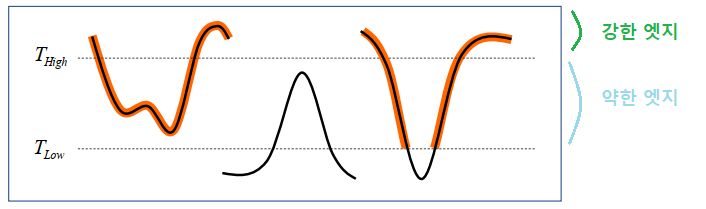

- `cv2.Canny(image, threshold1, threshold2, apertureSize=None)`
    - image: Canny 엣지 검출을 할 원본 이미지
    - threshold1: low threshold
    - threshold2: high threshold
        - threshold1과 threshold2 는 1:2 또는 1:3 정도 비율로 준다.
    - apertureSize: 소벨필터의 커널크기. default: 3

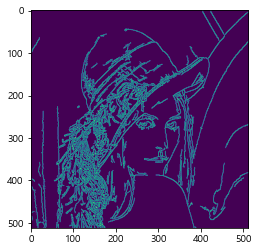

In [26]:
# (원본이미지, low TH, high TH)
lenna_canny = cv2.Canny(lenna_gray, 50, 150)
plt.imshow(lenna_canny)

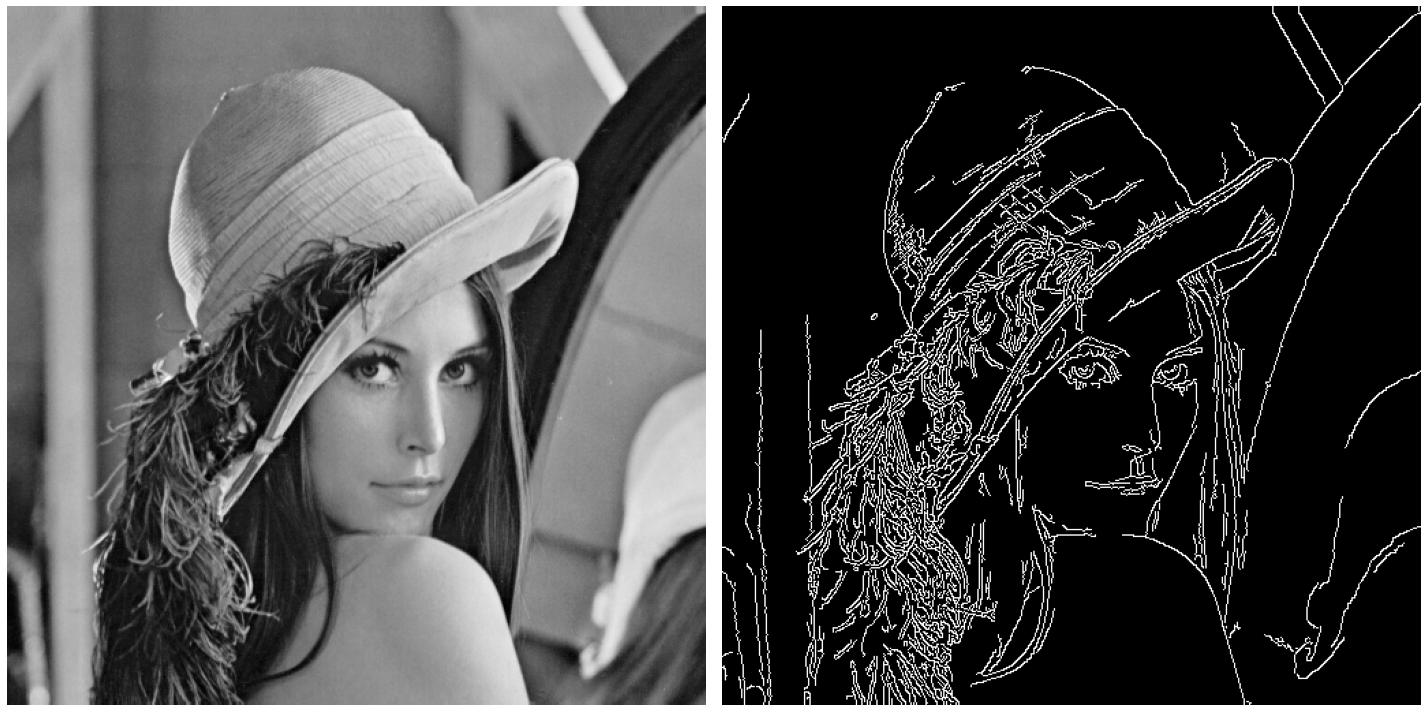

In [18]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(lenna_gray, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(lenna_canny, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# TODO
images/building.jpg 찾아보셔!

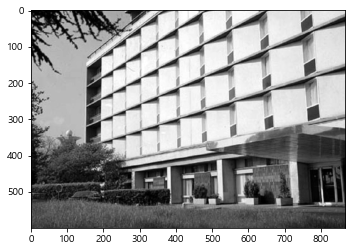

In [24]:
building = cv2.imread('images/building.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(building, cmap='gray')

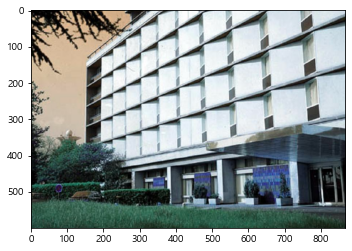

In [47]:
building2 = cv2.imread('images/building.jpg')

plt.imshow(building2)

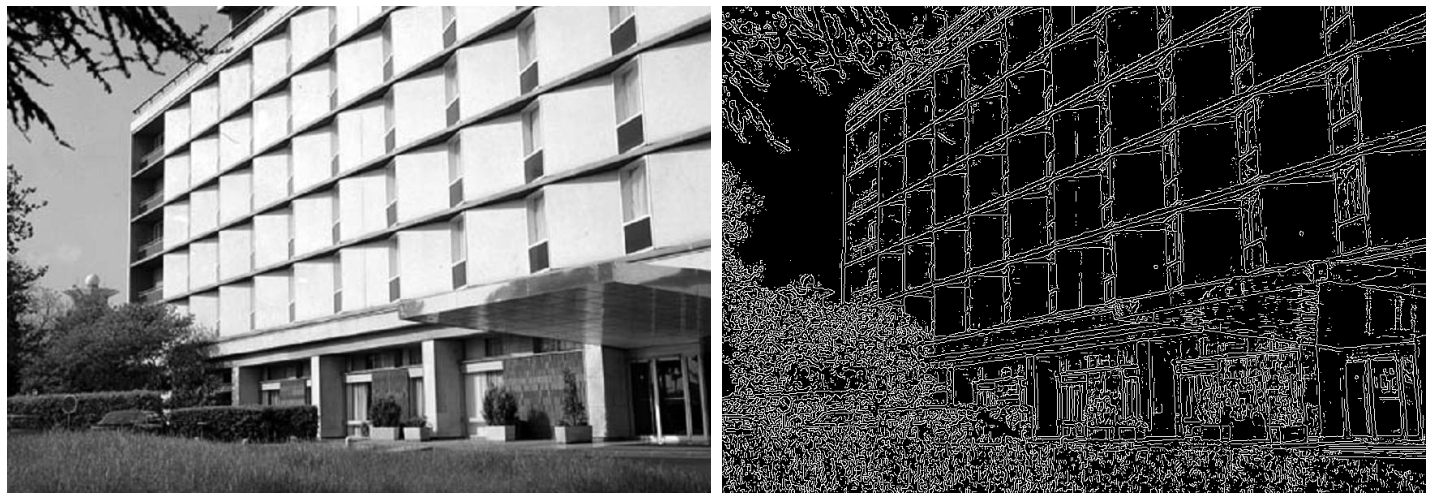

In [31]:
building_canny = cv2.Canny(building, 50, 50)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(building, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(building_canny, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

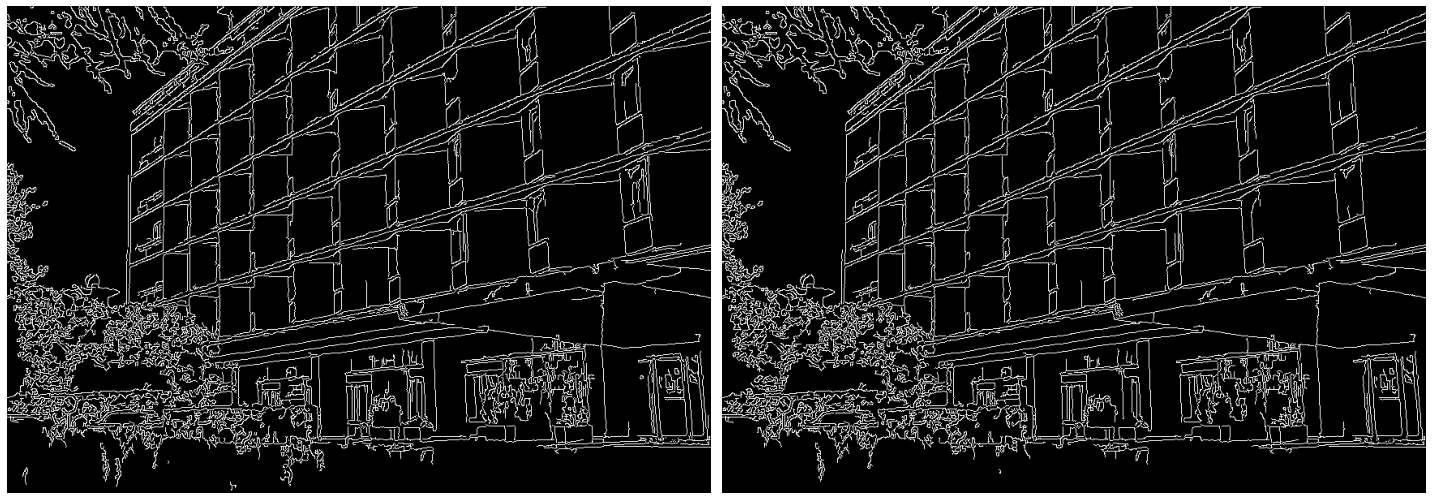

In [45]:
# (원본이미지, low TH, high TH)
building_canny1 = cv2.Canny(building, 50, 210)
building_canny2 = cv2.Canny(building, 50, 250)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(building_canny1, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(building_canny2, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

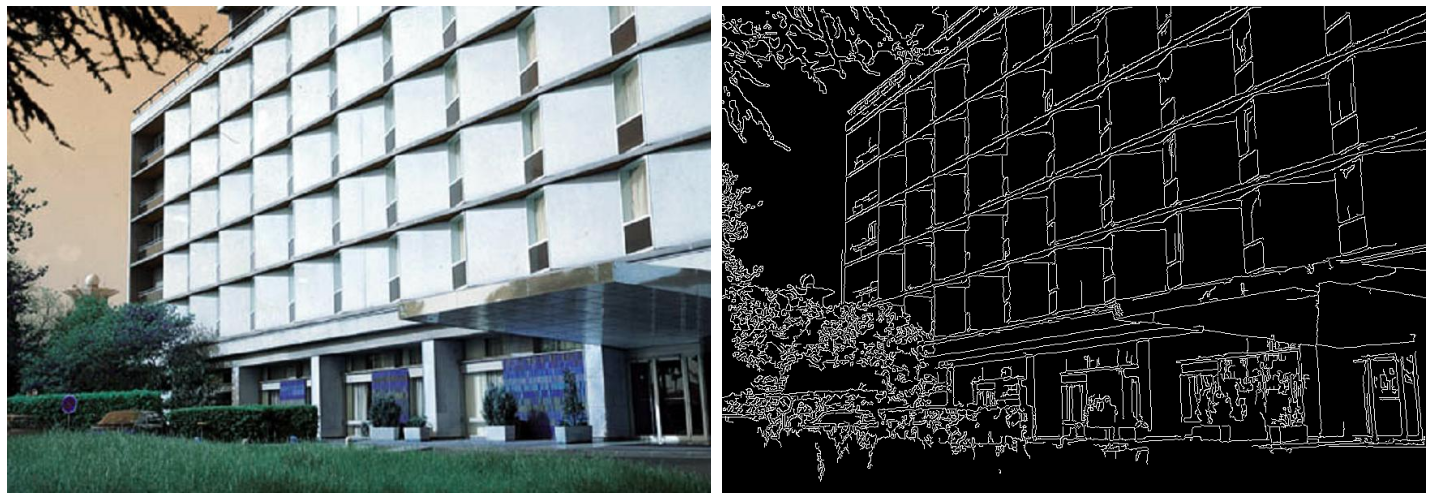

In [50]:
building_canny = cv2.Canny(building, 50, 250)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(building2, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(building_canny, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()